# **Analyse et prétraitement**

- Ce projet est basé sur le [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) qui contient plus de 20 000 images de chiens réparties en 120 classes (races de chien). Ce dataset a été élaboré à partir d'images et leur annotation provenant d'[ImageNet](https://www.image-net.org/), dont le contenu est utilisable gratuitement dans le cadre d'une utilisation non commerciale, ce qui est le cas ici.

- Dans le cadre de ce projet, pour des raisons matérielles, **nous n'utiliserons que la moitié des classes, soit 60 classes**. 

<div class="alert alert-info">
Chaque classe possède un nombre restreint d'échantillons. Afin d'améliorer les performances de nos modèles à venir, il pourra être intéressant de procéder à des techniques de data augmentation. <b>L'étape de data augmentation sera directement intégrée dans nos modèles lors de leur construction.</b> Nous allons ici nous focaliser sur l'analyse et les prétraitements de base des images.
</div>

Fonctionne avec : 
- matplotlib 3.7.0
- numpy 1.26.0
- pillow (PIL) 10.1.0
- tensorflow 2.15.0

In [1]:
import matplotlib.pyplot as plt  # Visualisations
import numpy as np  # Manipulations d'array

# Importation, traitement et enregistrement d'images
from PIL import Image
from PIL.ImageFilter import MedianFilter
from PIL.ImageEnhance import Contrast
from PIL.ImageOps import autocontrast, equalize, pad, fit, grayscale

# Utilisé pour le ZCA Whitening
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob  # Récupération des emplacements de fichiers
import os  # Manipulations de fichiers
import shutil  # Pour supprimer un dossier non vide
from collections import Counter  # Pour compter les occurences des labels
from collections import defaultdict  # Servira pour supprimer les doublons
import copy  # Utilisé pour importer un grand nombre de fichiers
import time  # Mesures des durées d'éxécution

### **Mesure de la durée d'exécution du notebook**

In [2]:
t_notebook = time.time()

## **A). Chargement des fichiers**

In [3]:
path = "dogs_medium/"  # Localisation des images du dataset
data_path = glob(path+'*/*.jp*')  # Récupération des chemins de tous les fichiers

In [4]:
debut = time.time()  # Heure de début du traitement

# Récupération des noms des dossiers (qui représentent les noms des labels)
# [len(path):] pour ne récupérer que les noms des dossiers, sans le chemin
list_labels = [os.path.dirname(dossier)[len(path):] for dossier in data_path]

# Récupération des noms des fichiers pour la gestion des doublons 
# et la sauvegarde à la fin de nos traitements
file_names = [os.path.basename(dossier) for dossier in data_path]

# Ouverture des images avec PIL.image
# L'utilisation de copy.deepcopy() permet d'éviter les erreurs
# lors de l'ouverture d'un grand nombre de fichiers avec Image.open()
img_pil = [copy.deepcopy(Image.open(ligne)) for ligne in data_path]

print(f"Durée du chargement : {(time.time() - debut):.2f} s")

Durée du chargement : 17.96 s


### **Gestion des doublons**

<div class="alert alert-info">
Des doublons sont présents dans ce dataset : au sein de mêmes classes, mais aussi entre certaines classes. Tout d'abord, ceci va introduire un biais au moment de passer les images dans nos modèles, surtout avec les doublons interclasse. De plus, la présence de ces doublons crée des erreurs au moment de la réalisation de la ZCA Whitening, qui débouche alors sur des images entièrement grises.
<br><br>
Pour supprimer les doublons, je me base sur la taille des fichiers. La probabilité que deux fichiers JPG représentant des choses différentes aient une taille identique à l'octet près étant faible, je juge la quantité d'images non doublonnées potentiellement perdues comme acceptable.
</div>

In [5]:
avec_doublon = len(img_pil)

# Créer un dictionnaire pour stocker les indices uniques par taille de fichier
unique_indices_dict = {}

# Remplir le dictionnaire avec les indices des images pour chaque classe
for i, file_name in enumerate(file_names):
    
    # Obtenir la taille du fichier
    file_size = os.path.getsize(data_path[i])

    # Utiliser une clé unique basée sur la taille du fichier
    key = (file_size)

    # Si la clé n'existe pas dans le dictionnaire, ajouter l'indice
    if key not in unique_indices_dict:
        unique_indices_dict[key] = i

# Utiliser les indices pour obtenir l'ensemble de données sans doublons
unique_indices = list(unique_indices_dict.values())

data_without_duplicates = [img_pil[i] for i in unique_indices]
list_labels_without_duplicates = [list_labels[i] for i in unique_indices]
file_names_without_duplicates = [file_names[i] for i in unique_indices]

# On réaffecte nos données sans doublons aux variables
img_pil = data_without_duplicates
list_labels = list_labels_without_duplicates
file_names = file_names_without_duplicates

print(f"{avec_doublon - len(img_pil)} doublons ont été supprimés.")

988 doublons ont été supprimés.


In [6]:
# Récupération des dimensions des images
largeur = [ligne.size[0] for ligne in img_pil]
hauteur = [ligne.size[1] for ligne in img_pil]
pixels = [ligne.size[0] * ligne.size[1] for ligne in img_pil]

## **B). Caractéristiques du dataset**

In [7]:
print(f"Nombre de classes : {len(set(list_labels))}")
print(f"Nombre de fichiers : {len(file_names)}")

print("\nClasses et images associées : ")
occurrences = Counter(list_labels)
for label, count in occurrences.items():
    print(f"'{label}' : {count} images.")

Nombre de classes : 60
Nombre de fichiers : 9663

Classes et images associées : 
'n02085620-Chihuahua' : 151 images.
'n02085782-Japanese_spaniel' : 184 images.
'n02085936-Maltese_dog' : 251 images.
'n02086079-Pekinese' : 145 images.
'n02086240-Shih-Tzu' : 211 images.
'n02086646-Blenheim_spaniel' : 183 images.
'n02086910-papillon' : 191 images.
'n02087046-toy_terrier' : 168 images.
'n02087394-Rhodesian_ridgeback' : 169 images.
'n02088094-Afghan_hound' : 233 images.
'n02088238-basset' : 171 images.
'n02088364-beagle' : 186 images.
'n02088466-bloodhound' : 178 images.
'n02088632-bluetick' : 162 images.
'n02089078-black-and-tan_coonhound' : 152 images.
'n02089867-Walker_hound' : 146 images.
'n02089973-English_foxhound' : 152 images.
'n02090379-redbone' : 137 images.
'n02090622-borzoi' : 143 images.
'n02090721-Irish_wolfhound' : 202 images.
'n02091032-Italian_greyhound' : 171 images.
'n02091134-whippet' : 179 images.
'n02091244-Ibizan_hound' : 170 images.
'n02091467-Norwegian_elkhound' : 18

### **Labels et fichiers**

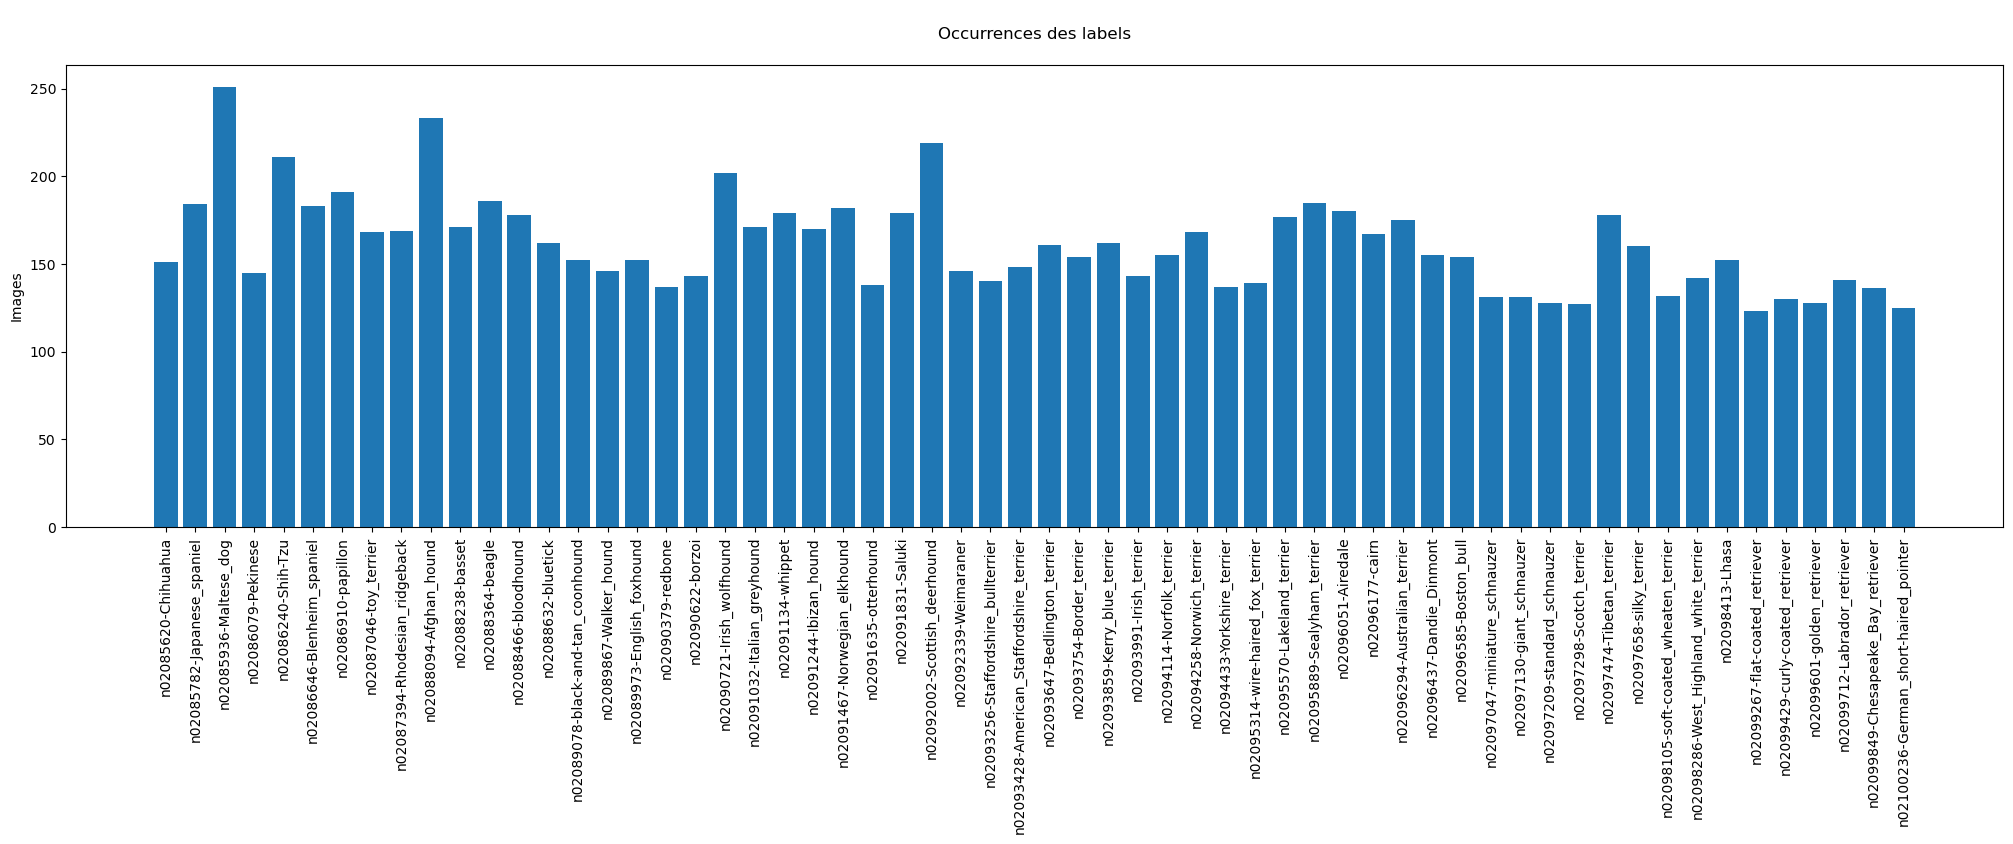

In [8]:
# On récupère les noms des labels et les occurences
# "*" dans zip() permet de passer en arguments séparés
# les paires clé-valeur renvoyées par occurrences.items()
labels, counts = zip(*occurrences.items())

# Graphique
plt.figure(figsize=(25, 6))
plt.bar(labels, counts)
plt.ylabel('Images')
plt.xticks(rotation=90, ha='center')
plt.title('\nOccurrences des labels\n')
plt.show()


### **Nombre de pixels des images**

Pixels maximale : 7990272
Pixels minimale : 10500
Pixels moyenne : 176463


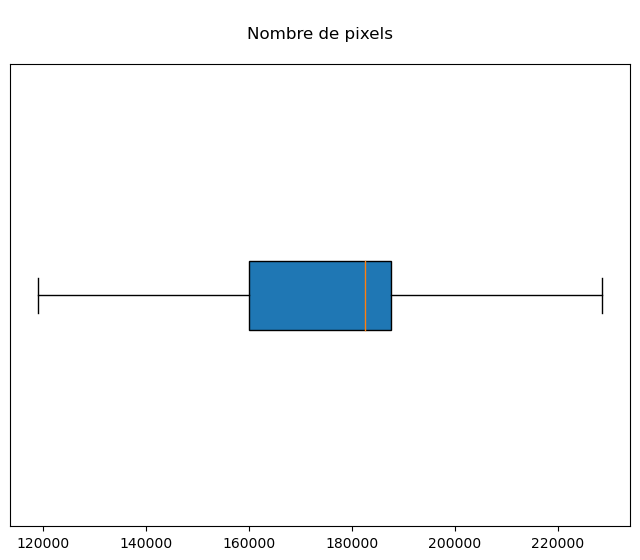

In [9]:
print(f"Pixels maximale : {max(pixels)}")
print(f"Pixels minimale : {min(pixels)}")
print(f"Pixels moyenne : {sum(pixels)/len(pixels):.0f}")

plt.figure(figsize=(8, 6))
plt.boxplot(pixels, vert=False, showfliers=False, patch_artist=True)
plt.title('\nNombre de pixels\n')
plt.yticks([])
plt.show()

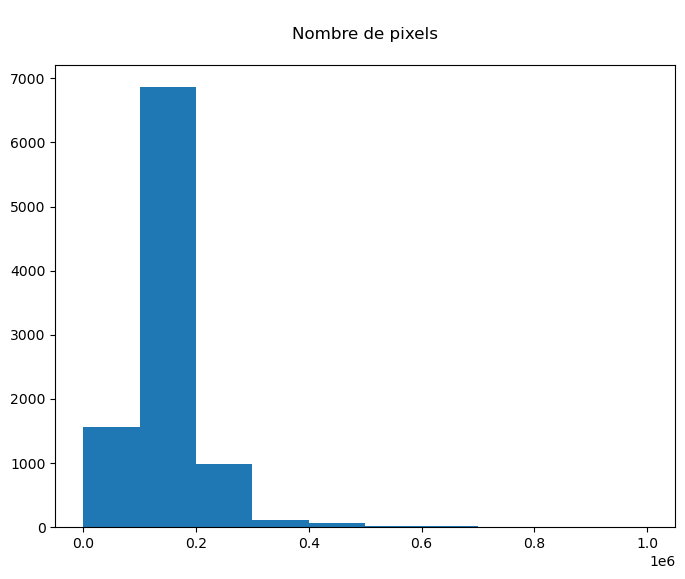

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(pixels, 10, range=(0, 1e6))
plt.title('\nNombre de pixels\n')
plt.show()

### **Largeurs**

Largeur maximale : 3264
Largeur minimale : 97
Largeur moyenne : 437


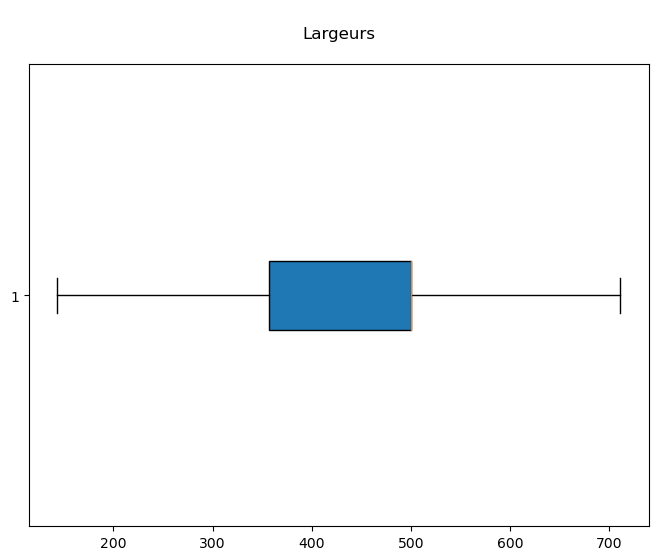

In [11]:
print(f"Largeur maximale : {max(largeur)}")
print(f"Largeur minimale : {min(largeur)}")
print(f"Largeur moyenne : {sum(largeur)/len(largeur):.0f}")

plt.figure(figsize=(8, 6))
plt.boxplot(largeur, vert=False, showfliers=False, patch_artist=True)
plt.title('\nLargeurs\n')
plt.show()

### **Hauteurs**

Hauteur maximale : 2562
Hauteur minimale : 100
Hauteur moyenne : 380


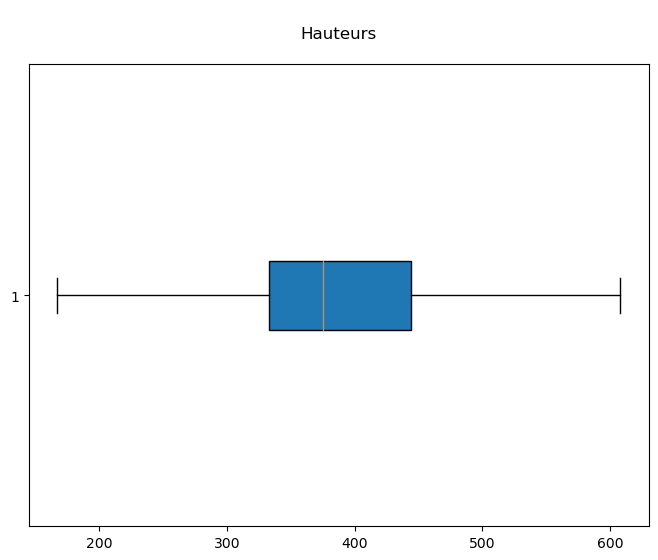

In [12]:
print(f"Hauteur maximale : {max(hauteur)}")
print(f"Hauteur minimale : {min(hauteur)}")
print(f"Hauteur moyenne : {sum(hauteur)/len(hauteur):.0f}")

plt.figure(figsize=(8, 6))
plt.boxplot(hauteur, vert=False, showfliers=False, patch_artist=True)
plt.title('\nHauteurs\n')
plt.show()

## **C). Traitement des images**

### **Fonction pour afficher les images et leur histogramme**

In [13]:
def image_shower(img):
    """
    Cette fonction permet d'afficher une image
    et ses histogramme (classique et cumulé)

    Prend en entrée une image PIL ou un array    
    """
    # Si l'image entrée n'est pas un array,
    # on le convertit
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    # Création d'une figure qui comportera l'image et les deux histogrammes
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Afficher l'image à gauche
    ax1.imshow(np.array(img), cmap='gray')  # cmap='gray' pour que l'image soit affichée en noir et blanc
                                            # s'il n'y a qu'un seul canal. Ce paramètre est ignoré si l'image est en RGB
    #ax1.axis('off')  # Si on souhaite masquer les axes sur l'image

    # Générer et afficher l'histogramme à droite
    ax2.hist(np.array(img).flatten(), bins=range(256))
    ax2.set_title('Histogramme')
    ax2.set_xlabel('Couleur')
    ax2.set_ylabel('Fréquence')
    ax2.set_xlim(0, 255)

    # Générer et afficher l'histogramme à droite
    ax3.hist(np.array(img).flatten(), bins=range(256), density=True, cumulative=True)
    ax3.set_title('Histogramme cumulé normalisé')
    ax3.set_xlabel('Couleur')
    ax3.set_ylabel('Fréquence')
    ax3.set_xlim(0, 255)

    plt.show()

### **Exemple d'image avant traitement**

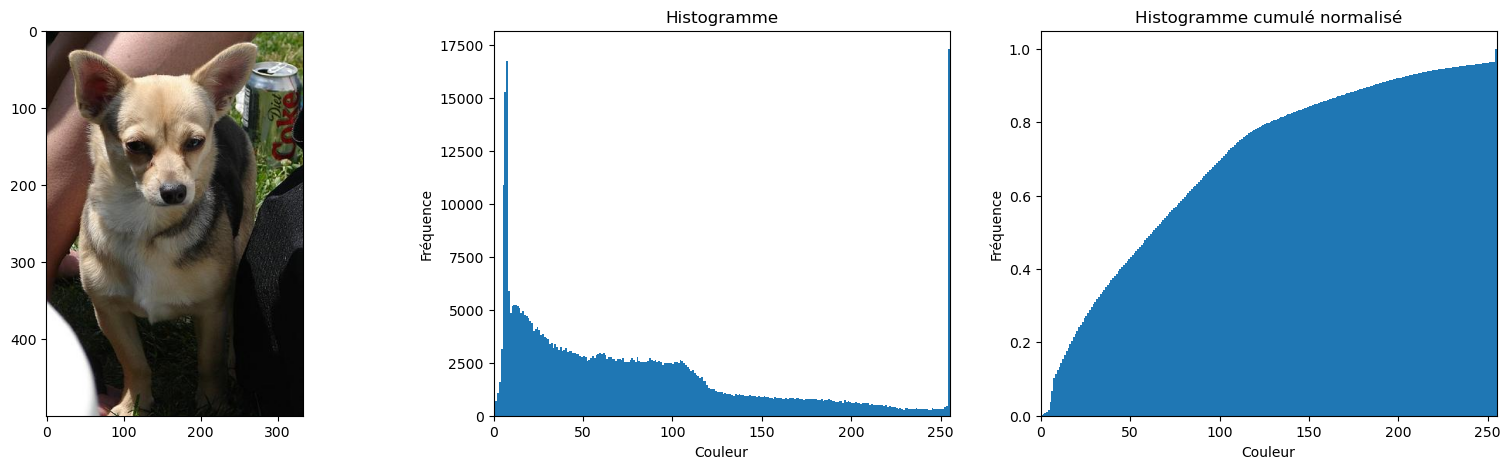

In [14]:
image_shower(img_pil[0])

### **1). Traitements génériques**

#### **Options de traitement**

In [15]:
# Redimentionnement
out_size = (299, 299)
resize_mod = "fit"  # Autre option "pad"

# Denoising
denoise = True

# Contraste supplémentaire
contrast = False
contrast_amount = 1.1

# Passage en niveau de gris
gray = False

#### **Redimensionnement**

Avant d'être passées dans nos modèles, il est préférable de redimensionner nos images, en format carré. Pour ce faire, deux approches sont possibles : 
- Approche *"fit"* : l'image est redimensionnée, l'aspect ratio est conservé, si besoin l'image est recadrée pour correspondre aux dimensions de sortie.<br>
**Avantage :** pas d'ajout de bruit ; **Défaut :** perte d'information
- Approche *"pad"* : l'image est redimensionnée, l'aspect ratio est conservé, si besoin l'image est comblée de noir pour correspondre aux dimensions de sortie.<br>
**Avantage :** pas de perte d'information ; **Défaut :** ajout de bruit (remplissage noir)

Durée du traitement : 16.77 s


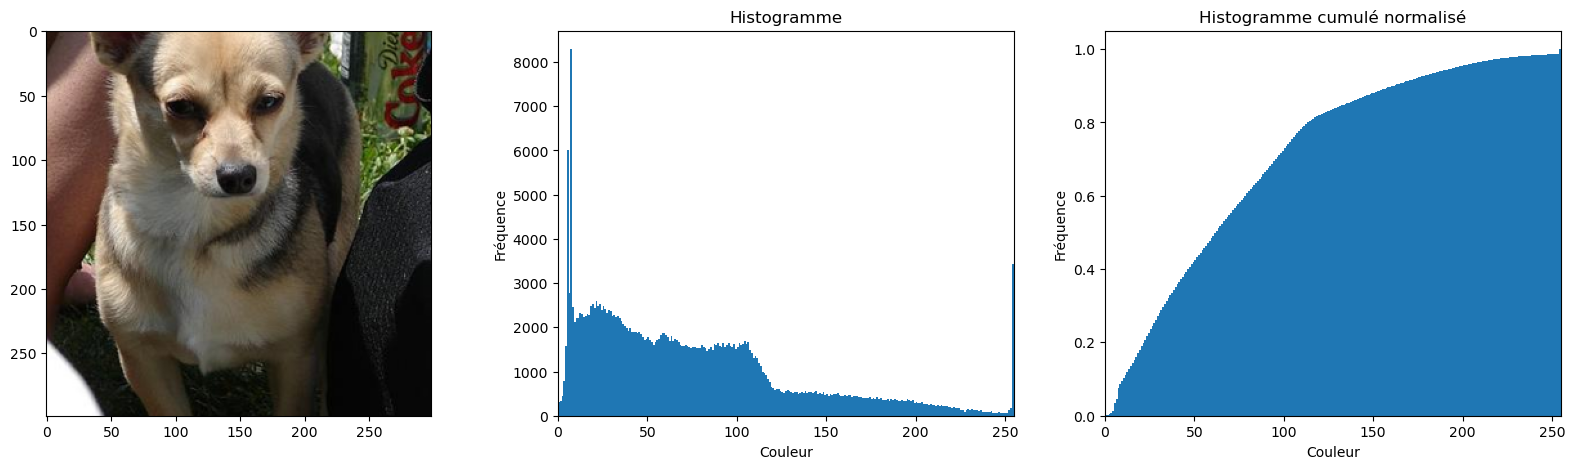

In [16]:
if resize_mod:

    debut = time.time()  # Heure de début du traitement

    for i in range(len(img_pil)):
        img = img_pil[i]
        if resize_mod == "fit":
            img = fit(img, out_size, bleed=0.0, centering=(0.5, 0.5))
        
        if resize_mod == "pad":
            img = pad(img, out_size, color=None, centering=(0.5, 0.5))
        
        # On remplace l'image d'origine par l'image traitée
        img_pil[i] = img

    print(f"Durée du traitement : {(time.time() - debut):.2f} s")
    
    # Exemple d'image après traitement 
    image_shower(img_pil[0])

else:
    print("Pas de redimensionnement.")

#### **Débruitage**

Débruitage de l'image à l'aide d'un filtre médian (non-linéaire) : la valeur de chaque pixel est remplacée par la médiane de son voisinage. Peut générer un peu de perte d'information.

Durée du traitement : 164.30 s


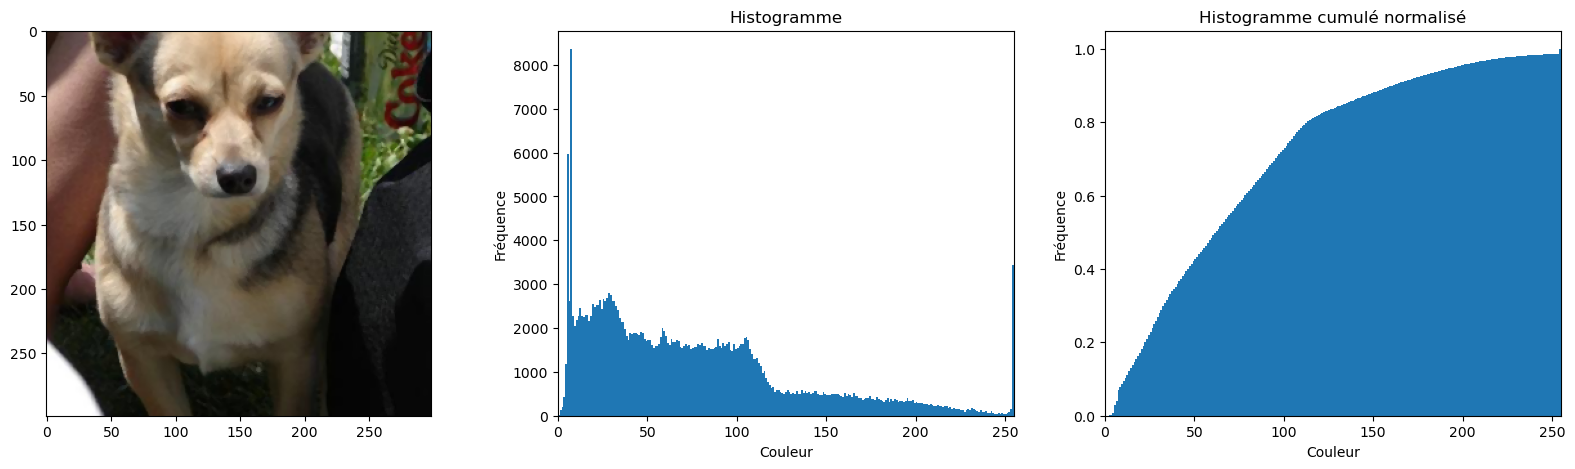

In [17]:
if denoise:

    debut = time.time()  # Heure de début du traitement
    
    for i in range(len(img_pil)):

        img = img_pil[i]

        # Denoising léger
        img = img.filter(MedianFilter(3))

        # On remplace l'image d'origine par l'image traitée
        img_pil[i] = img    

    print(f"Durée du traitement : {(time.time() - debut):.2f} s")    

    image_shower(img_pil[0])

else:
    print("Pas de débruitage.")

#### **Égalisation des histogrammes**

Le processus d'égalisation de l'histogramme fonctionne en redistribuant les intensités de pixel de manière à ce que l'histogramme cumulé soit uniforme. Cela signifie que les niveaux d'intensité d'origine, qui pourraient être concentrés dans certaines plages, sont étalés sur toute la plage des intensités possibles. En résultat, les zones sombres et claires de l'image peuvent apparaître plus distinctes.

Durée du traitement : 7.28 s


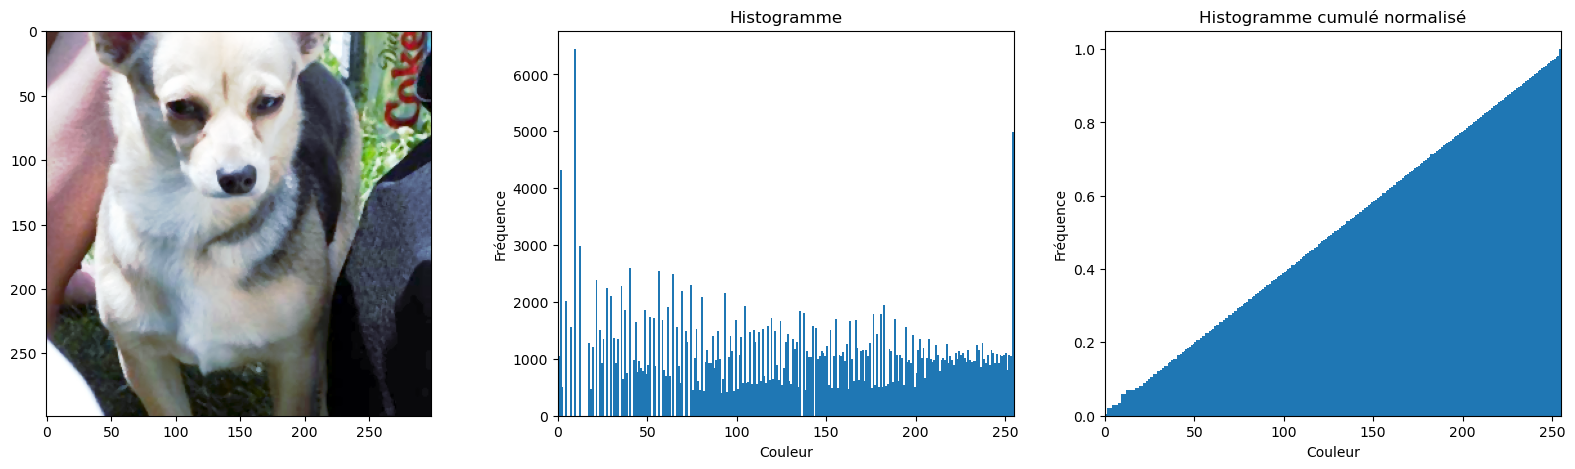

In [18]:
debut = time.time()  # Heure de début du traitement

for i in range(len(img_pil)):

    img = img_pil[i]

    img = equalize(img)
    
    # On remplace l'image d'origine par l'image traitée
    img_pil[i] = img

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

image_shower(img_pil[0])

#### **Contraste**

Le traitement *autocontrast* permet de normaliser le contraste de l'image. L'effet n'est donc visibile que sur les images dont le contrast serait trop faible ou trop fort.

Durée du traitement : 7.15 s


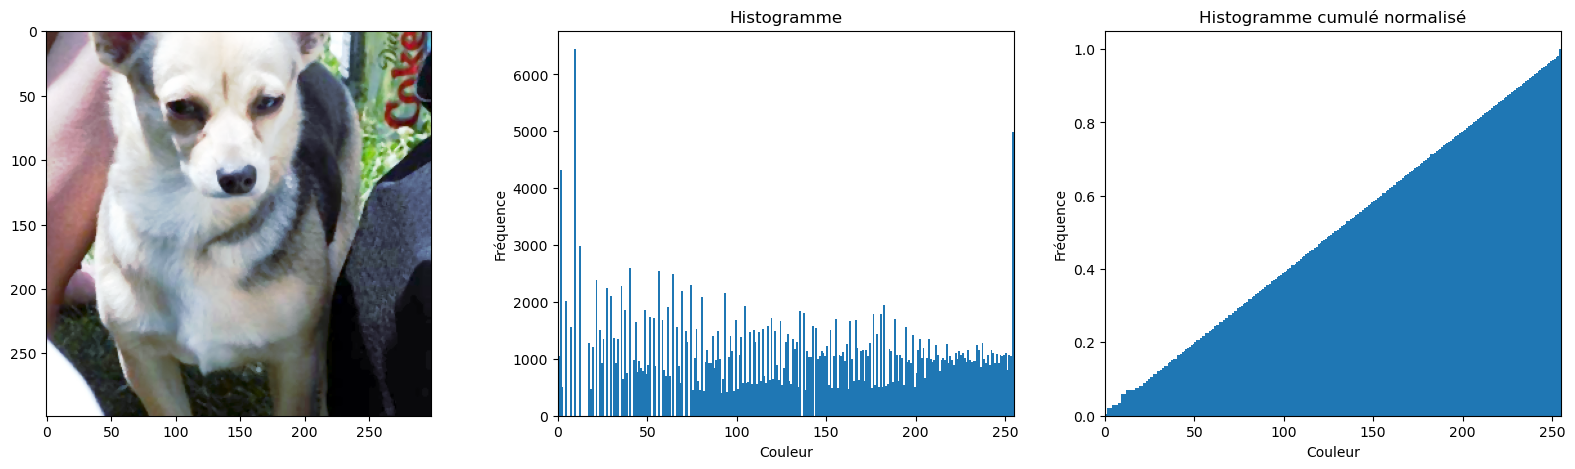

In [19]:
debut = time.time()  # Heure de début du traitement

for i in range(len(img_pil)):

    img = img_pil[i]

    img = autocontrast(img)

    # Ajout de contraste supplémentaire
    if contrast:
        img = Contrast(img).enhance(contrast_amount)

    # On remplace l'image d'origine par l'image traitée
    img_pil[i] = img

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

# Exemple d'image après traitement 
image_shower(img_pil[0])

#### **Passage en niveau de gris**

Le passage en niveau de gris permet de fortement réduire la dimensionnalité de nos données, permettant d'accélérer les calculs lors du passage des images dans nos modèles. La contrepartie est une perte d'information, puisque les images n'ont plus de couleur.

In [20]:
if gray:

    debut = time.time()  # Heure de début du traitement

    for i in range(len(img_pil)):

        img = img_pil[i]

        img = grayscale(img)

        # On remplace l'image d'origine par l'image traitée
        img_pil[i] = img

    
    image_shower(img_pil[0])

    print(f"Durée du traitement : {(time.time() - debut):.2f} s")

else:
    print("Pas de niveau de gris.")

Pas de niveau de gris.


### **Exemple d'image après tous les traitements**

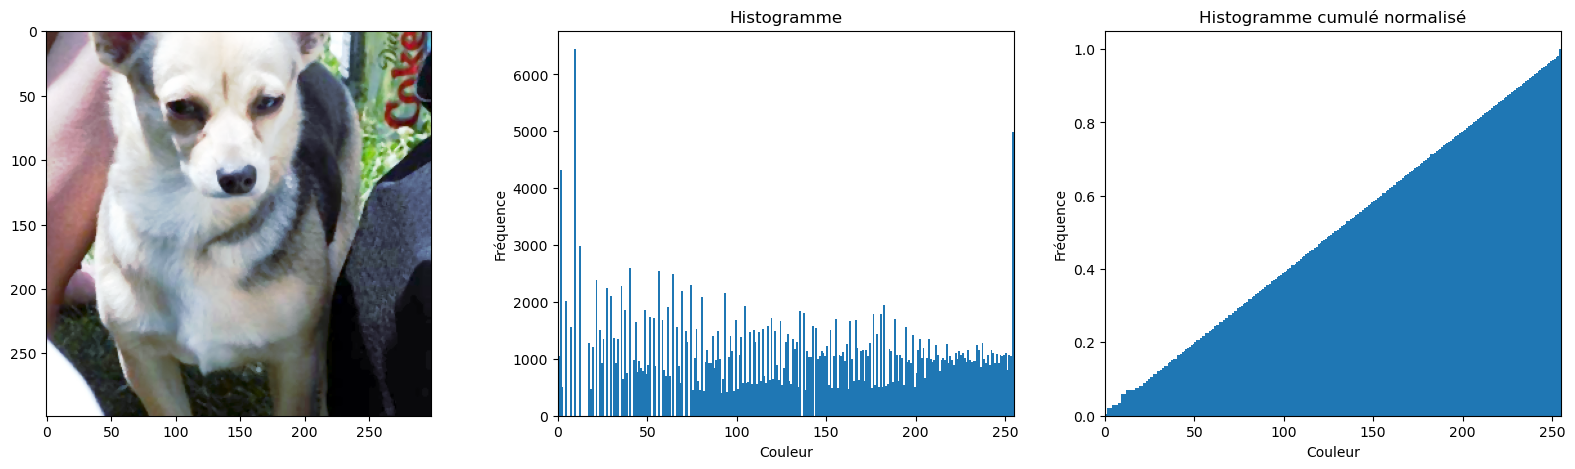

In [21]:
image_shower(img_pil[0])

### **2). ZCA Whitening**

La ZCA (Zero Component Analysis) whitening est basée sur la PCA (Principal Component Analysis). Avec la ZCA whitening, la dernière étape comporte une multiplication de matrice supplémentaire avec la matrice de valeurs propres. Cette technique permet de mieux conserver la structure des données que la PCA whitening, mais est plus coûteuse en terme de calculs. Avec cette technique les images transformées ressemblent plus aux images originales. Plus d'infos [ici](https://www.aiplusinfo.com/blog/pca-whitening-vs-zca-whitening-what-is-the-difference/)<br>

Le module *ImageDataGenerator* de Keras possède une implémentation de la ZCA whitening.

<div class="alert alert-info">
Cette technique est coûteuse en ressources, notamment en mémoire vive. En effet, la matrice de corrélation qui va être crée lors du processus aura pour dimension <i>hauteur × largeur × canaux</i> des images, ce qui peut vite donner des dimensions très grandes en fonction de la taille des images. Pour cette raison, les images vont être redimensionnées en 100x100 pour ce traitement.
</div>

#### **Redimensionnement des images avant ZCA Whitening**

In [22]:
# Dans cette liste seront stockée les images 100x100
img_pil_white = []

debut = time.time()  # Heure de début du traitement

for i in range(len(img_pil)):
    
    img = img_pil[i]

    img = fit(img, (100, 100), bleed=0.0, centering=(0.5, 0.5))
    
    # On remplace l'image d'origine par l'image traitée
    img_pil_white.append(img)

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 5.53 s


#### **Conversion de notre liste d'images PIL en array**

In [23]:
image_array_list = [np.array(img) for img in img_pil_white]
img_array = np.stack(image_array_list)

# Si l'image est en niveau de gris, un reshape doit être fait
if gray:
    img_array = img_array.reshape((-1, out_size[0], out_size[1], 1))
    
print(f"Dimensions de l'array d'images : {img_array.shape}")

Dimensions de l'array d'images : (9663, 100, 100, 3)


#### **Entraînement du modèle**

In [24]:
X = img_array

debut = time.time()  # Heure de début du traitement

datagen = ImageDataGenerator(featurewise_center=True,  # Centrer les valeurs sur 0 (nécessaire pour zca_whitening=True)
                             featurewise_std_normalization=False,  # False requis pour zca_whitening=True
                             zca_whitening=True
)

# Entraînement
datagen.fit(X)

print(f"Durée de l'entraînement : {(time.time() - debut):.2f} s")

Durée de l'entraînement : 508.66 s


#### **Création des images avec whitening**

In [25]:
# Création d'un array vide aux bonnes dimensions
# On y mettra nos batchs successifs d'images traitées
all_whitened_images = np.zeros((0,) + (X.shape[1:]))

debut = time.time()  # Heure de début du traitement

for batch in datagen.flow(X, batch_size=9, shuffle=False):
    whitened_images = batch
    all_whitened_images = np.concatenate((all_whitened_images, whitened_images), axis=0)

    if len(all_whitened_images) >= len(X):
        break

print(f"Durée de création des images : {(time.time() - debut):.2f} s")
print(f"Forme de l'array de sortie : {all_whitened_images.shape}")

Durée de création des images : 1840.91 s
Forme de l'array de sortie : (9663, 100, 100, 3)


#### **Reconvertion des images traitées dans un format RGB classique**

In [26]:
all_whitened_images_conv_list = []

for i in range(all_whitened_images.shape[0]):

    img = all_whitened_images[i]

    m, M = img.min(), img.max()

    img = (img - m) / (M - m)

    img = (img * 255).astype(np.uint8)

    all_whitened_images_conv_list.append(img)


#### **Exemples d'images traitées**

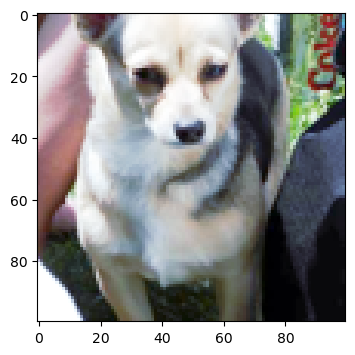

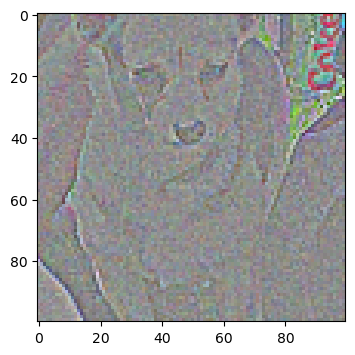

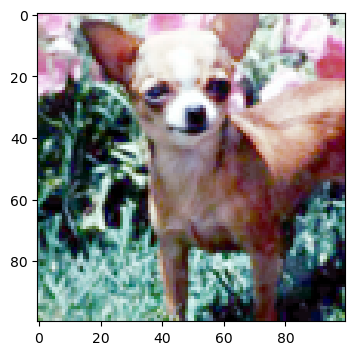

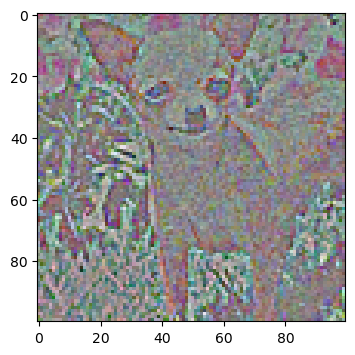

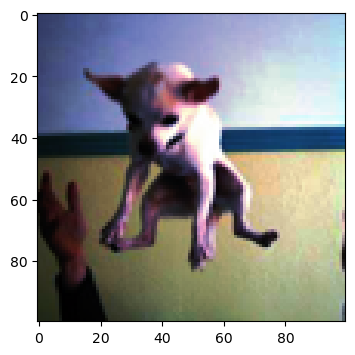

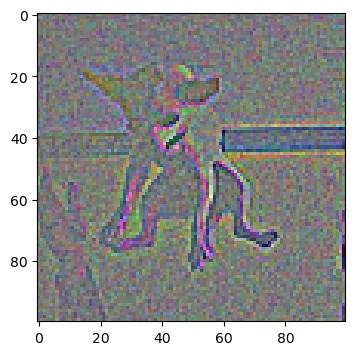

In [27]:
def show2(img):

    plt.figure(figsize = (4, 4))
    plt.imshow(img, cmap='gray')  # cmap='gray' pour que l'image soit affichée en noir et blanc
                                  # s'il n'y a qu'un seul canal. Ce paramètre est ignoré si l'image est en RGB
    plt.show()

for i in range(3):
    show2(X[i])
    show2(all_whitened_images_conv_list[i])


## **D). Enregistrement des images traitées**

In [28]:
def save_file(images=None, suffixe="_proc"):

    """
    Cette fonction permet de sauvegarder nos images dans des fichiers.
    Elle prend en entrée une liste d'array ou une liste d'images PIL.
    """

    if not images:
        return "Vous devez indiquer les images à sauvegarder"
    
    # Dossier de sauvegarde : même nom que celui d'origine + suffixe
    dossier = path[:-1]+suffixe

    # Si le dossier existe déjà (précédente sauvagarde)
    # suppression du dossier et de son contenu avec shutil
    if os.path.exists(path[:-1]+suffixe):
        shutil.rmtree(dossier)

    # Création du dossier
    os.mkdir(dossier)

    # Récupération du nom des labels
    unique_labels = list(set(list_labels))

    # Création des sous dossiers qui auront le nom de chaque label
    for i in range(len(unique_labels)):
        os.mkdir(path[:-1]+suffixe+"/"+unique_labels[i])

    # Cas où les images sont stockées dans une liste d'array
    # On vérifie avec le premier élément de la liste
    if isinstance(images[0], np.ndarray):
        # Enregistrement de chaque image dans son dossier respectif
        for i in range(len(images)):
            im = Image.fromarray(images[i])
            im.save(dossier+"/"+list_labels[i]+"/"+file_names[i])
    
    # Cas où les images sont stockée dans une liste d'image PIL
    else:    
        # Enregistrement de chaque image dans son dossier respectif
        for i in range(len(images)):
            images[i].save(dossier+"/"+list_labels[i]+"/"+file_names[i])

In [29]:
do_save_file = False

#### **Enregistrement des images avec traitements de base**

In [30]:
if do_save_file:
    save_file(images=img_pil, suffixe="_proc")

#### **Enregistrement des images avec traitements de base + ZCA Whitening**

In [31]:
if do_save_file:
    save_file(images=all_whitened_images_conv_list, suffixe="_proc_white")

### **Mesure de la durée d'exécution du notebook**

In [32]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 43:26
